In [319]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.result.utils import marginal_counts
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# Shor's code algorithm

The Shor's code algorithm encodes a single qubit into a 9-qubit entangled state.
Qubits 0, 3, and 6 are the data qubits, while the others are repetition qubits.

In [320]:
def encode_shor(circuit):
    """Encodes a single qubit using the Shor code."""
    circuit.cx(0, 3) # Copy state from qubit 0 to qubit 3
    circuit.cx(0, 6) # Copy state from qubit 0 to qubit 6
    circuit.h([0, 3, 6])
    for i in [0, 3, 6]:
        circuit.cx(i, i+1)
        circuit.cx(i, i+2)

def bit_flip_correction(circuit):
    """Corrects bit-flip errors using majority voting."""
    # Iterate over the groups of qubits (0-2, 3-5, 6-8)
    for i in [0, 3, 6]:
        # Apply majority voting within each group
        circuit.cx(i, i+1)
        circuit.cx(i, i+2)
        circuit.ccx(i+1, i+2, i)  # Correct the main qubit if needed
    return circuit

def phase_flip_correction(circuit):
    """Corrects phase-flip errors by applying Hadamard gates and correcting bit flips."""
    # Apply Hadamard gates to the logical qubits (0, 3, 6)
    for i in [0, 3, 6]:
        circuit.h(i)
    # Apply majority voting
    circuit.cx(0, 3)
    circuit.cx(0, 6)
    circuit.ccx(6, 3, 0)  # Correct the main qubit if needed
    return circuit

Circuit without error correction to simulate noisy channel

In [321]:
# Circuit without error correction
circuit_no_correction = QuantumCircuit(9)
encode_shor(circuit_no_correction)
# Simulate a bit-flip error on data qubit
circuit_no_correction.x(0)
# Simulate a phase-flip error on data qubit
circuit_no_correction.z(0)
state_no_correction = Statevector.from_instruction(circuit_no_correction)

In [322]:
state_no_correction.draw("latex")

<IPython.core.display.Latex object>

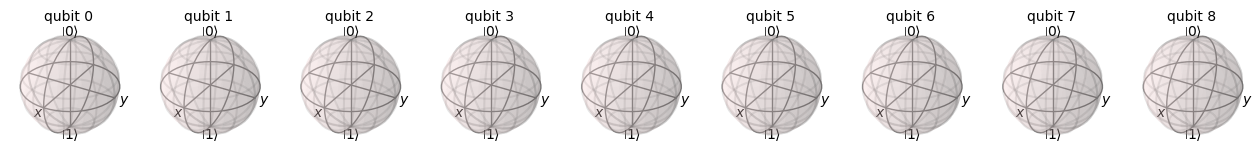

In [323]:
plot_bloch_multivector(state_no_correction)

In [324]:
circuit_no_correction.measure_all()

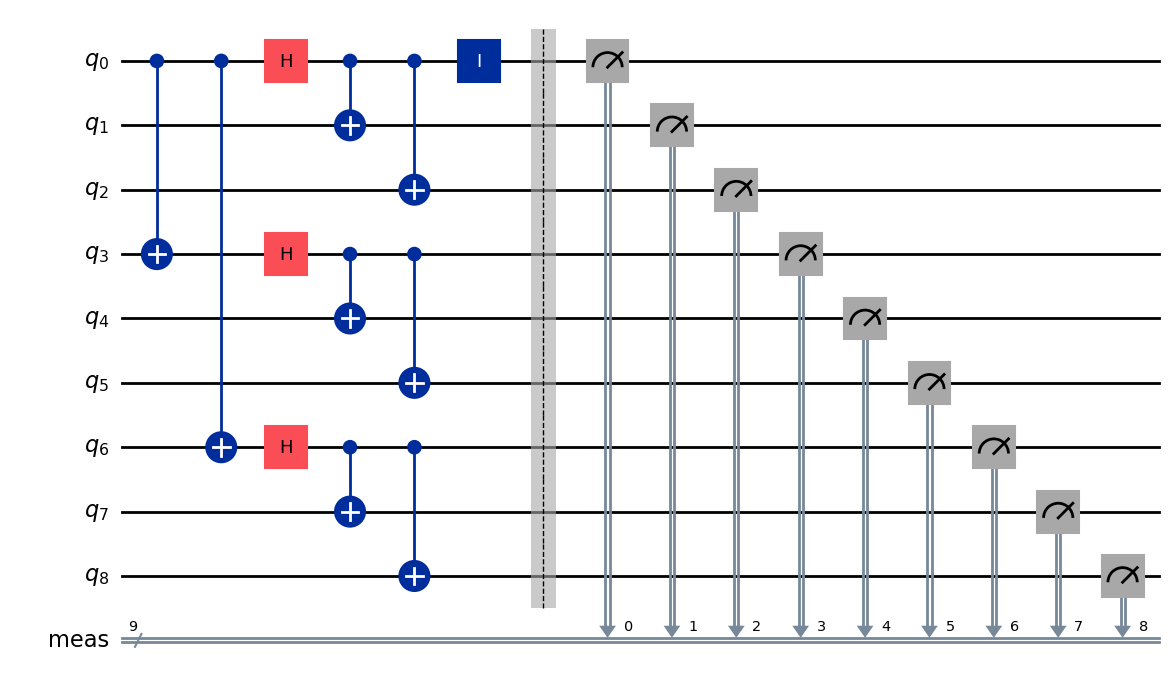

In [325]:
circuit_no_correction.draw('mpl')

Circuit with error correction to simulate noisy channel with Shor code correction

In [326]:
# Circuit with error correction
circuit_with_correction = QuantumCircuit(9)
encode_shor(circuit_with_correction)
# Simulate a bit-flip error on data qubit
circuit_with_correction.x(0)
# Simulate a phase-flip error on data qubit
circuit_with_correction.z(0)
circuit_with_correction.barrier()
# Perform error correction
bit_flip_correction(circuit_with_correction)
phase_flip_correction(circuit_with_correction)
state_with_correction = Statevector.from_instruction(circuit_with_correction)

In [327]:
state_with_correction.draw("latex")

<IPython.core.display.Latex object>

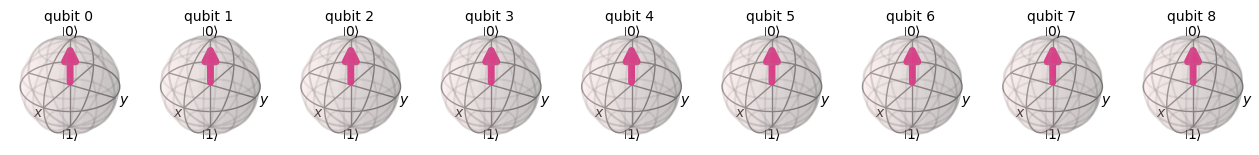

In [328]:
plot_bloch_multivector(state_with_correction)

In [329]:
circuit_with_correction.measure_all()

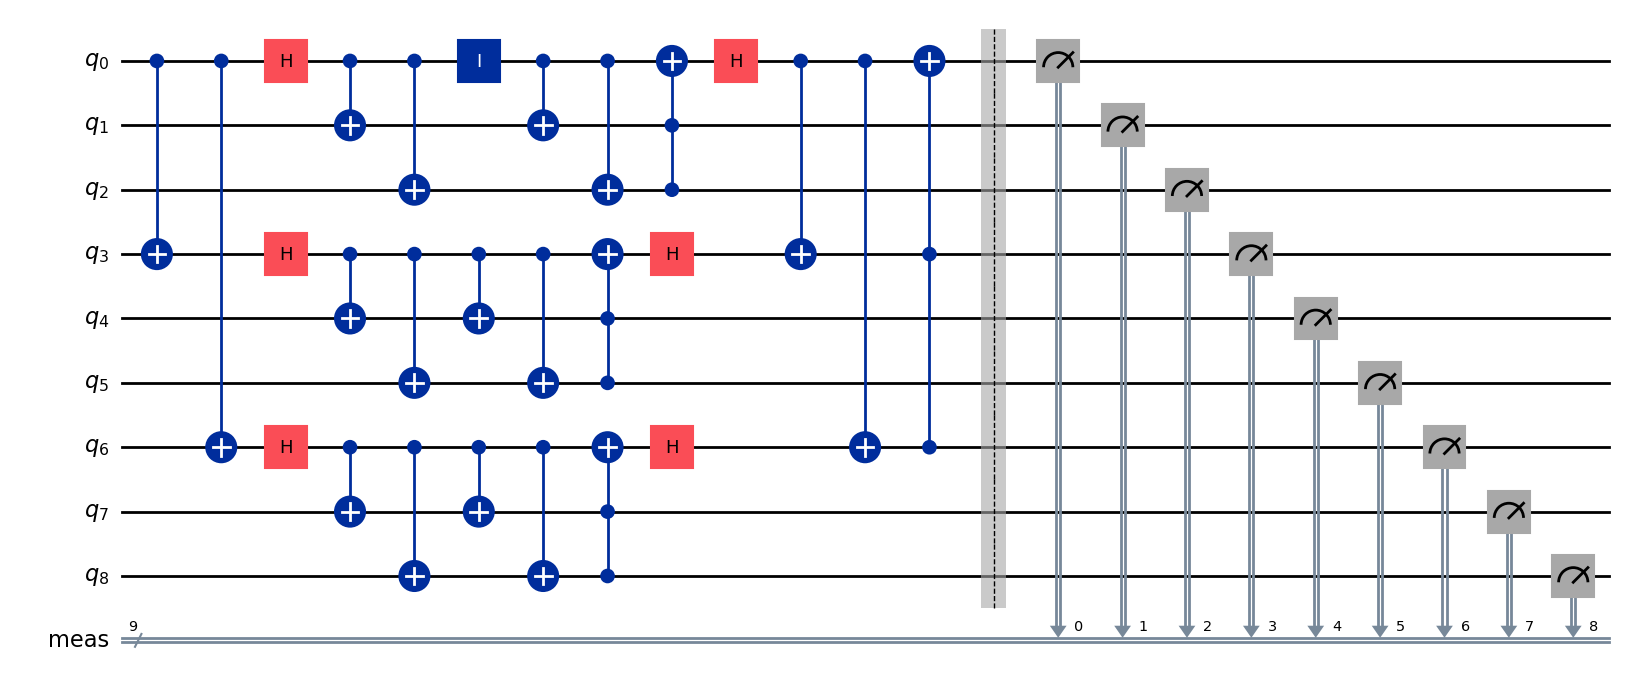

In [330]:
circuit_with_correction.draw('mpl')

Simulation

In [ ]:
backend = Aer.get_backend('qasm_simulator')
compiled_no_correction = transpile(circuit_no_correction, backend)
compiled_with_correction = transpile(circuit_with_correction, backend)
results_no_correction = backend.run(compiled_no_correction, shots=1024).result()
results_with_correction = backend.run(compiled_with_correction, shots=1024).result()
marginal_no_correction = marginal_counts(results_no_correction.get_counts(), indices=[0])
marginal_with_correction = marginal_counts(results_with_correction.get_counts(), indices=[0])

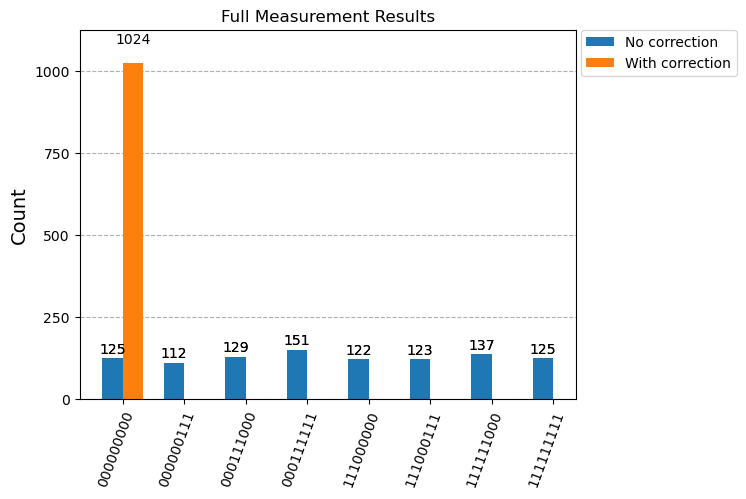

In [334]:
plot_histogram([results_no_correction.get_counts(), results_with_correction.get_counts()],
               legend=['No correction', 'With correction'],
               title="Full Measurement Results")

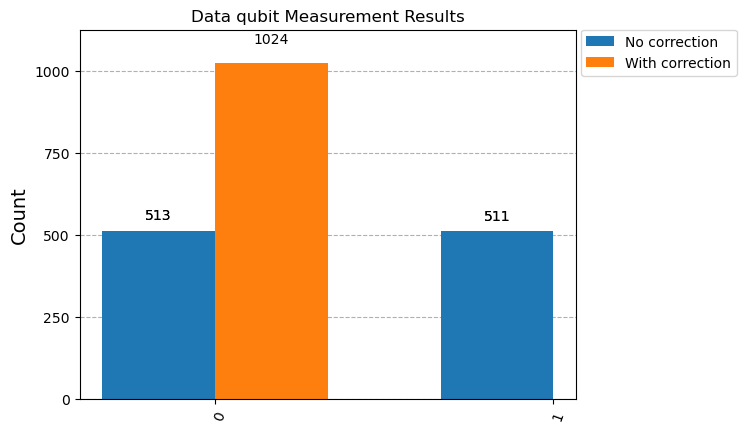

In [335]:
plot_histogram([marginal_no_correction, marginal_with_correction],
               legend=['No correction', 'With correction'],
               title="Data qubit Measurement Results")